In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

import warnings
warnings.filterwarnings("ignore")

In [16]:
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
cbm_dropcast = pd.read_excel('bacbm2-processed-sensor_data.xlsx')

x_data = cbm_dropcast['concentration (mg/L)']
y_data = cbm_dropcast['cbm mean']
y_std = cbm_dropcast['cbm std']

In [3]:
X = np.log10(x_data[:, np.newaxis])

### Bayesian Ridge

In [4]:
model = BayesianRidge()
model.fit(X, y_data)

y_pred, y_std_pred = model.predict(X, return_std=True)

print(f"Intercepto: {model.intercept_}")
print(f"Coeficiente: {model.coef_}")

Intercepto: 12.463653962742566
Coeficiente: [3.8712483]


In [10]:
from sklearn.metrics import r2_score

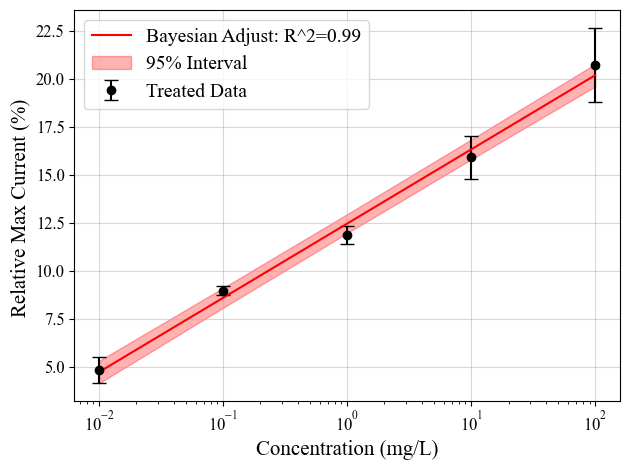

In [21]:
r2 = r2_score(y_data, y_pred)

plt.errorbar(x_data, y_data, yerr=y_std, fmt='o', capsize=5, label='Treated Data', color='black')
plt.plot(x_data, y_pred, label=f'Bayesian Adjust: R^2={round(r2,2)}', color='r')
plt.fill_between(x_data, y_pred - y_std_pred, y_pred + y_std_pred, color='r', alpha=0.3, label='95% Interval')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Concentration (mg/L)',fontsize=15)
plt.ylabel('Relative Max Current (%) ',fontsize=15)

plt.xscale('log')
plt.legend(fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.savefig('bayesian_adjust.png',dpi=500,transparent=True)
plt.show()

### Optimized Bayesian Ridge

In [40]:
import optuna
from sklearn.metrics import mean_squared_error

In [41]:
def objective(trial):
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-6, 1e-1)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-6, 1e-1)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-6, 1e-1)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-6, 1e-1)

    model = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
    model.fit(X, y_data)
    
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y_data, y_pred)
    
    return mse

In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-10-11 10:51:06,674] A new study created in memory with name: no-name-b6ccc989-8219-4c09-a735-913d03c8f16b
[I 2024-10-11 10:51:06,682] Trial 0 finished with value: 0.1965236722126186 and parameters: {'alpha_1': 0.0016100047156567664, 'alpha_2': 9.429901842121776e-05, 'lambda_1': 0.00808252561096192, 'lambda_2': 1.2278327219201653e-06}. Best is trial 0 with value: 0.1965236722126186.
[I 2024-10-11 10:51:06,689] Trial 1 finished with value: 0.1965390705837796 and parameters: {'alpha_1': 0.08017071812265145, 'alpha_2': 0.001190250233735044, 'lambda_1': 0.07364995319135709, 'lambda_2': 0.00010582689487924286}. Best is trial 0 with value: 0.1965236722126186.
[I 2024-10-11 10:51:06,696] Trial 2 finished with value: 0.19656468682475955 and parameters: {'alpha_1': 6.607483849109617e-05, 'alpha_2': 0.028924337807943207, 'lambda_1': 0.08630805695377866, 'lambda_2': 0.000197729769130413}. Best is trial 0 with value: 0.1965236722126186.
[I 2024-10-11 10:51:06,703] Trial 3 finished with valu

In [43]:
# Melhores hiperparâmetros
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.19651359800230822
  Params: 
    alpha_1: 0.09958858629924294
    alpha_2: 1.1931714820545874e-05
    lambda_1: 0.0004219970660887723
    lambda_2: 0.013130552842303021


In [45]:
best_params = trial.params
model = BayesianRidge(**best_params)
model.fit(X, y_data)

y_pred, y_std_pred = model.predict(X, return_std=True)

print(f"Intercepto: {model.intercept_}")
print(f"Coeficiente: {model.coef_}")

Intercepto: 12.463653962742566
Coeficiente: [3.871554]


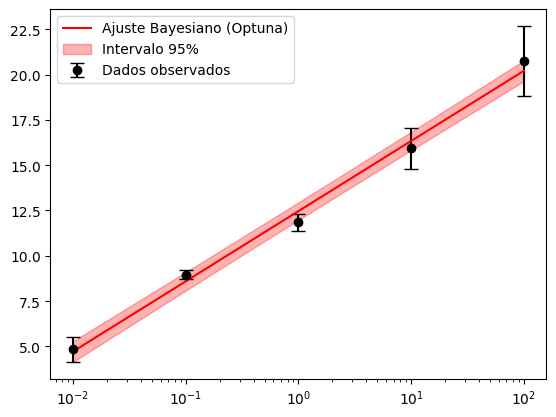

In [48]:
plt.errorbar(x_data, y_data, yerr=y_std, fmt='o', capsize=5, label='Dados observados', color='black')
plt.plot(x_data, y_pred, label='Ajuste Bayesiano (Optuna)', color='r')
plt.fill_between(x_data, y_pred - y_std_pred, y_pred + y_std_pred, color='r', alpha=0.3, label='Intervalo 95%')
plt.xscale('log')
plt.legend()
plt.show()